In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# from /mdistiller/mdistiller/distillers/KD.py (hinton kd)
def kd_loss(logits_student, logits_teacher, temperature):
    log_pred_student = F.log_softmax(logits_student / temperature, dim=1)
    pred_teacher = F.softmax(logits_teacher / temperature, dim=1)
    loss_kd = F.kl_div(log_pred_student, pred_teacher, reduction="none").sum(1).mean()
    loss_kd *= temperature**2
    return loss_kd

In [3]:
batch_size = 1
num_logits = 5

fake_data = torch.randn(batch_size, num_logits)
fake_out = fake_data + torch.randn(batch_size, num_logits)*0.5
fake_data ,fake_out

(tensor([[ 0.1999, -0.2893,  2.9475,  0.2612,  1.0793]]),
 tensor([[-0.0844, -1.1990,  2.9200,  0.5978,  0.9859]]))

In [4]:
kd_loss(fake_data,fake_out,1.0) #this is correct just fyi.  it takes a batch, returns a scalar.  i didn't know that lol


tensor(0.0126)

In [5]:
class CosineDistanceLoss(nn.Module):
    def __init__(self):
        super(CosineDistanceLoss, self).__init__()
    
    def forward(self, output, target):
        # Cosine similarity
        cosine_similarity = F.cosine_similarity(output, target)
        # Convert to distance
        cosine_distance = 1 - cosine_similarity
        return cosine_distance.mean()

In [6]:
def sldcd_loss(logits_student, logits_teacher):
    batch_size = logits_teacher.shape[0]
    shuffled_labels = logits_teacher[[batch_size - 1] + [i for i in range(batch_size - 1)]]
    cosine_dist = 1 - F.cosine_similarity(logits_student - shuffled_labels, logits_teacher - shuffled_labels )
    return cosine_dist.mean()

In [7]:
sldcd_loss(fake_data,fake_data) #this is working it seems

tensor(1.)

In [8]:
fake_out
batch_size = fake_out.shape[0]
fake_out[[batch_size - 1] + [i for i in range(batch_size - 1)]]

tensor([[-0.0844, -1.1990,  2.9200,  0.5978,  0.9859]])

In [9]:
F.softmax(fake_data, dim = 1), F.softmax(fake_data*2, dim = 1)

(tensor([[0.0483, 0.0296, 0.7542, 0.0514, 0.1165]]),
 tensor([[0.0040, 0.0015, 0.9670, 0.0045, 0.0231]]))

In [10]:
fake_data.shape

torch.Size([1, 5])

In [11]:
random_number = torch.rand(1).item()
random_number

0.14254289865493774

In [12]:
def mse(logits_student, logits_teacher):
    mse_loss = F.mse_loss(logits_student, logits_teacher, reduction='mean')
    return mse_loss

In [13]:
mse(fake_data,fake_out)

tensor(0.2062)

In [61]:
b_s = 3
logit_num = 4
logits = torch.rand(b_s, logit_num)
print(logits)
logits_expanded_1 = logits.unsqueeze(1)  # Expands to (64, 1, 10)
logits_expanded_2 = logits.unsqueeze(0)  # Expands to (1, 64, 10)

# Subtract the tensors, resulting in a (64, 64, 10) tensor
# Each element in the batch is subtracted from every other element, making the diagonals 0
resultant_tensor = logits_expanded_1 - logits_expanded_2

##this is pretent outputs
mlogits = torch.rand(b_s, logit_num)
print(mlogits)
mlogits_expanded_1 = mlogits.unsqueeze(1)  # Expands to (64, 1, 10)
mlogits_expanded_2 = mlogits.unsqueeze(0)  # Expands to (1, 64, 10)

# Subtract the tensors, resulting in a (64, 64, 10) tensor
# Each element in the batch is subtracted from every other element, making the diagonals 0
mresultant_tensor = mlogits_expanded_1 - mlogits_expanded_2

tensor([[0.1300, 0.9295, 0.0090, 0.7884],
        [0.6726, 0.3128, 0.5114, 0.8454],
        [0.9910, 0.3537, 0.8739, 0.6454]])
tensor([[0.1455, 0.6272, 0.9989, 0.3352],
        [0.4480, 0.9484, 0.9018, 0.1874],
        [0.2450, 0.2721, 0.6975, 0.4047]])


In [15]:
resultant_tensor, mresultant_tensor

(tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [-0.2595, -0.8384,  0.8348,  ...,  0.1543, -0.0079, -0.2668],
          [-0.0588, -0.2912,  0.6883,  ..., -0.2435,  0.1189, -0.4383],
          ...,
          [-0.0601, -0.0600,  0.8908,  ..., -0.0586,  0.1923, -0.2334],
          [-0.4334, -0.4449,  0.8308,  ...,  0.0572,  0.0191, -0.3169],
          [-0.0431, -0.1000,  0.4034,  ..., -0.1949, -0.6598,  0.0850]],
 
         [[ 0.2595,  0.8384, -0.8348,  ..., -0.1543,  0.0079,  0.2668],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.2006,  0.5472, -0.1465,  ..., -0.3979,  0.1268, -0.1716],
          ...,
          [ 0.1994,  0.7784,  0.0559,  ..., -0.2129,  0.2002,  0.0333],
          [-0.1739,  0.3936, -0.0040,  ..., -0.0971,  0.0270, -0.0501],
          [ 0.2164,  0.7385, -0.4314,  ..., -0.3492, -0.6519,  0.3517]],
 
         [[ 0.0588,  0.2912, -0.6883,  ...,  0.2435, -0.1189,  0.4383],
          [-0.2006, -0.5472,

In [16]:
x = 1 - F.cosine_similarity(resultant_tensor,mresultant_tensor, dim = -1)
x

tensor([[1.0000, 0.9916, 0.9786,  ..., 1.0309, 1.0135, 0.9620],
        [0.9916, 1.0000, 1.0042,  ..., 0.9650, 0.9661, 0.9815],
        [0.9786, 1.0042, 1.0000,  ..., 0.9775, 0.9971, 0.9925],
        ...,
        [1.0309, 0.9650, 0.9775,  ..., 1.0000, 0.9992, 0.9829],
        [1.0135, 0.9661, 0.9971,  ..., 0.9992, 1.0000, 0.9986],
        [0.9620, 0.9815, 0.9925,  ..., 0.9829, 0.9986, 1.0000]])

In [17]:
x.sum() -4

tensor(65611.9297)

In [18]:
resultant_tensor

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.2595, -0.8384,  0.8348,  ...,  0.1543, -0.0079, -0.2668],
         [-0.0588, -0.2912,  0.6883,  ..., -0.2435,  0.1189, -0.4383],
         ...,
         [-0.0601, -0.0600,  0.8908,  ..., -0.0586,  0.1923, -0.2334],
         [-0.4334, -0.4449,  0.8308,  ...,  0.0572,  0.0191, -0.3169],
         [-0.0431, -0.1000,  0.4034,  ..., -0.1949, -0.6598,  0.0850]],

        [[ 0.2595,  0.8384, -0.8348,  ..., -0.1543,  0.0079,  0.2668],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.2006,  0.5472, -0.1465,  ..., -0.3979,  0.1268, -0.1716],
         ...,
         [ 0.1994,  0.7784,  0.0559,  ..., -0.2129,  0.2002,  0.0333],
         [-0.1739,  0.3936, -0.0040,  ..., -0.0971,  0.0270, -0.0501],
         [ 0.2164,  0.7385, -0.4314,  ..., -0.3492, -0.6519,  0.3517]],

        [[ 0.0588,  0.2912, -0.6883,  ...,  0.2435, -0.1189,  0.4383],
         [-0.2006, -0.5472,  0.1465,  ...,  0

In [19]:
def batch_differences_cosine_distance(logits_student, logits_teacher):
    batch_size = logits_teacher.shape[0]
    student_differences = logits_student.unsqueeze(1) - logits_student.unsqueeze(0)
    teacher_differences = logits_teacher.unsqueeze(1) - logits_teacher.unsqueeze(0)
    print(student_differences,teacher_differences)
    cosine_dist = 1 - F.cosine_similarity(student_differences, teacher_differences, dim = -1 )
    return cosine_dist.sum() - batch_size #this gets rid of the ones on diag. 

def batch_differences_cosine_distance(logits_student, logits_teacher):
    batch_size = logits_teacher.shape[0]
    student_differences = logits_student.unsqueeze(1) - logits_student.unsqueeze(0)
    teacher_differences = logits_teacher.unsqueeze(1) - logits_teacher.unsqueeze(0)
    cosine_dist = 1 - F.cosine_similarity(student_differences, teacher_differences, dim = -1 )
    eye = torch.eye(batch_size)
    cosine_dist = cosine_dist - eye
    return cosine_dist.mean()

In [20]:
x = torch.tensor([0.1,0.1,0.1])
y = torch.tensor([0.1,0.1,0.1])
1 - F.cosine_similarity(x, y, dim = -1 )

tensor(5.9605e-08)

In [21]:
logits,mlogits

(tensor([[0.1433, 0.0899, 0.9054,  ..., 0.4086, 0.2175, 0.5025],
         [0.4028, 0.9284, 0.0706,  ..., 0.2542, 0.2254, 0.7693],
         [0.2022, 0.3812, 0.2172,  ..., 0.6521, 0.0986, 0.9409],
         ...,
         [0.2034, 0.1500, 0.0147,  ..., 0.4671, 0.0252, 0.7360],
         [0.5767, 0.5348, 0.0746,  ..., 0.3513, 0.1984, 0.8194],
         [0.1864, 0.1899, 0.5021,  ..., 0.6034, 0.8773, 0.4176]]),
 tensor([[0.4984, 0.7778, 0.2903,  ..., 0.4644, 0.2997, 0.2338],
         [0.0645, 0.0519, 0.1347,  ..., 0.7958, 0.8936, 0.9063],
         [0.2881, 0.4640, 0.0094,  ..., 0.8255, 0.9478, 0.8351],
         ...,
         [0.0729, 0.1950, 0.5966,  ..., 0.4308, 0.4037, 0.9627],
         [0.9169, 0.8804, 0.4609,  ..., 0.6189, 0.6686, 0.6036],
         [0.7222, 0.5569, 0.1543,  ..., 0.4772, 0.8398, 0.4075]]))

In [22]:
batch_differences_cosine_distance(logits,mlogits)

tensor(0.9973)

In [23]:
def bd_mse(logits_student, logits_teacher):
    student_differences = logits_student.unsqueeze(1) - logits_student.unsqueeze(0)
    teacher_differences = logits_teacher.unsqueeze(1) - logits_teacher.unsqueeze(0)
    mse_loss = F.mse_loss(student_differences, teacher_differences, reduction='mean')  
    return mse_loss

In [24]:
bd_mse(logits,mlogits)

tensor(0.3323)

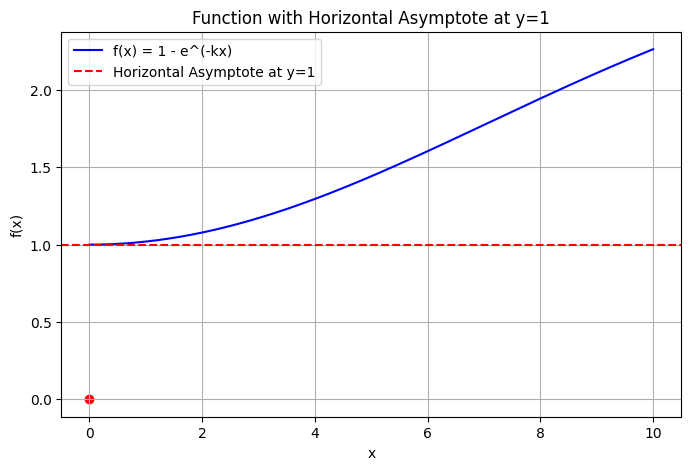

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function with a specific k value
j = 2
k = 0.01
e=2
f = lambda x: 1 + j*(1 - np.exp(-k*x**e))

# Generate x values from 0 to 10
x = np.linspace(0, 10, 400)
y = f(x)

# Plot the function
plt.figure(figsize=(8, 5))
plt.plot(x, y, label='f(x) = 1 - e^(-kx)', color='blue')
plt.axhline(y=1, color='red', linestyle='--', label='Horizontal Asymptote at y=1')
plt.scatter([0], [0], color='red')  # Origin point
plt.title('Function with Horizontal Asymptote at y=1')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
j = 0.1 #where is the asymptote.  This needs to be low so your products don't overflow.  depends on batch size
k = 0.5 #hyper param.  how bunched up by the origin do you want the gradient slope.  lower flattens it out, higher squeezes it close to zero

# Define the function using PyTorch operations
def FLP(x, j = 1, k = 1, e = 1): #(flatter for Lots of Products)
    return 1 + j * (1 - torch.exp(-k * x**e))


In [27]:
x

array([ 0.        ,  0.02506266,  0.05012531,  0.07518797,  0.10025063,
        0.12531328,  0.15037594,  0.1754386 ,  0.20050125,  0.22556391,
        0.25062657,  0.27568922,  0.30075188,  0.32581454,  0.35087719,
        0.37593985,  0.40100251,  0.42606516,  0.45112782,  0.47619048,
        0.50125313,  0.52631579,  0.55137845,  0.5764411 ,  0.60150376,
        0.62656642,  0.65162907,  0.67669173,  0.70175439,  0.72681704,
        0.7518797 ,  0.77694236,  0.80200501,  0.82706767,  0.85213033,
        0.87719298,  0.90225564,  0.9273183 ,  0.95238095,  0.97744361,
        1.00250627,  1.02756892,  1.05263158,  1.07769424,  1.10275689,
        1.12781955,  1.15288221,  1.17794486,  1.20300752,  1.22807018,
        1.25313283,  1.27819549,  1.30325815,  1.3283208 ,  1.35338346,
        1.37844612,  1.40350877,  1.42857143,  1.45363409,  1.47869674,
        1.5037594 ,  1.52882206,  1.55388471,  1.57894737,  1.60401003,
        1.62907268,  1.65413534,  1.67919799,  1.70426065,  1.72

In [28]:
 FLP(logits, j = 0.1, k = 0.1)

tensor([[1.0014, 1.0009, 1.0087,  ..., 1.0040, 1.0022, 1.0049],
        [1.0039, 1.0089, 1.0007,  ..., 1.0025, 1.0022, 1.0074],
        [1.0020, 1.0037, 1.0021,  ..., 1.0063, 1.0010, 1.0090],
        ...,
        [1.0020, 1.0015, 1.0001,  ..., 1.0046, 1.0003, 1.0071],
        [1.0056, 1.0052, 1.0007,  ..., 1.0035, 1.0020, 1.0079],
        [1.0018, 1.0019, 1.0049,  ..., 1.0059, 1.0084, 1.0041]])

In [29]:
def batch_contrastive_products(logits_student, logits_teacher,option = 0, j = 0.1, k = 0.1, mse_k = 0.1):
    batch_size = logits_teacher.shape[0]
    student_differences = logits_student.unsqueeze(1) - logits_student.unsqueeze(0)
    teacher_differences = logits_teacher.unsqueeze(1) - logits_teacher.unsqueeze(0)
    cosine_dist = 2 - F.cosine_similarity(student_differences, teacher_differences, dim = -1 ) #1 means identical 3 is opposite
    cosine_dist = cosine_dist - torch.eye(batch_size) #gets rid of the 2 along the diag
    
    mse_loss = F.mse_loss(student_differences, teacher_differences, reduction='none').mean(dim=-1) #1 means exactly the same
    in_range_mse_loss = FLP(mse_loss,j=2, k=mse_k) #try this for now.  this puts mse in the same range as cd above
    agg_loss = cosine_dist * in_range_mse_loss
    
    if option == 0:
        return agg_loss.mean()
    if option == 1:
        #this does an inter batch product to try not to rob patricia to pay pauline
        if batch_size % 2 == 0:
            halves = torch.chunk(agg_loss, 2, dim=0)
            inter_batch_prod = halves[0] * halves[1]
            return inter_batch_prod.mean()
        else:
            return agg_loss.mean()
    if option == 2:
        #this will collapse along the batch dim with products before mean.
        squashed_loss = FLP( agg_loss-1, j, k)
        prod_red_loss = torch.prod(squashed_loss, dim = 0)
        return prod_red_loss.mean()
    
    if option == 3:
        #full product collapse.  no robbing any of the apostles to pay any of the others.  full gradient communism
        squashed_loss = FLP( agg_loss-1, j, k)
        prod_red_loss = torch.prod(squashed_loss)
        
        return prod_red_loss.mean()

In [30]:
batch_contrastive_products(logits,   mlogits, option = 3, j = 1.0, k = 0.1, mse_k = 0.1)

tensor(inf)

In [31]:
logits, logits + 1000

(tensor([[0.1433, 0.0899, 0.9054,  ..., 0.4086, 0.2175, 0.5025],
         [0.4028, 0.9284, 0.0706,  ..., 0.2542, 0.2254, 0.7693],
         [0.2022, 0.3812, 0.2172,  ..., 0.6521, 0.0986, 0.9409],
         ...,
         [0.2034, 0.1500, 0.0147,  ..., 0.4671, 0.0252, 0.7360],
         [0.5767, 0.5348, 0.0746,  ..., 0.3513, 0.1984, 0.8194],
         [0.1864, 0.1899, 0.5021,  ..., 0.6034, 0.8773, 0.4176]]),
 tensor([[1000.1433, 1000.0900, 1000.9055,  ..., 1000.4086, 1000.2175,
          1000.5026],
         [1000.4028, 1000.9284, 1000.0706,  ..., 1000.2542, 1000.2254,
          1000.7693],
         [1000.2021, 1000.3812, 1000.2172,  ..., 1000.6521, 1000.0986,
          1000.9409],
         ...,
         [1000.2034, 1000.1500, 1000.0147,  ..., 1000.4671, 1000.0252,
          1000.7360],
         [1000.5767, 1000.5348, 1000.0746,  ..., 1000.3513, 1000.1984,
          1000.8194],
         [1000.1864, 1000.1899, 1000.5021,  ..., 1000.6034, 1000.8773,
          1000.4175]]))

In [32]:
1.5**32

431439.8832739892

In [33]:
def FLP(x, j = 1, k = 1, e = 1): #(flatter for Lots of Products)
    return 1 + j * (1 - torch.exp(-k * x**e))

def batch_contrastive_products_loss_interaction(logits_student
                                                , logits_teacher
                                                , option = 0
                                                , collapse_option = 0
                                                , j = 0.1
                                                , k = 0.1
                                                , k_o = 0.1
                                                , j_o = 0.1):
    batch_size = logits_teacher.shape[0]
    student_differences = logits_student.unsqueeze(1) - logits_student.unsqueeze(0)
    teacher_differences = logits_teacher.unsqueeze(1) - logits_teacher.unsqueeze(0)
    cosine_dist = 1 - F.cosine_similarity(student_differences, teacher_differences, dim = -1 ) 
    
    cosine_dist = cosine_dist - torch.eye(batch_size).to(cosine_dist.device) #gets rid of the 2 along the diag
    
    squasehd_product = FLP(cosine_dist,j=j, k=k, e=2)
    collapsed_products = torch.prod(squasehd_product, dim = -1).unsqueeze(1) #1 to (1+j) ^^batchsize
    
    if option == 0:
        """
        uses mse, 
        """
        sample_loss = F.mse_loss(logits_student, logits_teacher, reduction='none') + 1 #1 to infinity
        
    if option == 1:
        sample_loss = 2 - F.cosine_similarity(logits_student, logits_teacher, dim=-1) #1 to 3...
    
    if collapse_option == 0:
        print(sample_loss)
        return (collapsed_products*sample_loss).mean()
    
    if collapse_option == 1:
        pre_squashed = (collapsed_products*sample_loss) - 1 
        squashed_output = FLP(pre_squashed,j=j_o, k=k_o, e = 2)
        return torch.prod(squashed_output)

In [34]:
batch_contrastive_products_loss_interaction(logits,logits,option = 1, collapse_option = 1, j=0.5, k=0.1)

tensor(1.)

In [35]:
1.2**64, 1.12**128, 1.5**32 #some j values

(116842.20576272637, 1994834.643278906, 431439.8832739892)

In [36]:
but j is dependent on the batch big time. you want a number that doesn't overflow.   


SyntaxError: unterminated string literal (detected at line 1) (2840387486.py, line 1)

In [ ]:
high k means you have to be really close to the right answer to get the loss reduction.  i think i want a high k.
with no momentum? it is a shallow gradient for a long time, then it drops then flattens out just right in front of the correct loss.  
it should be a low lr.
mmm, not sure this is true.  a lower k, like, under 1, gives me wider range of values with more informative gradients.  and with the exponent i still have breaks on it? 

In [ ]:
logits.shape, mlogits.shape

In [ ]:
def cosine_dist(logits_student, logits_teacher):
    cosine_distance = 2 - F.cosine_similarity(logits_student, logits_teacher)
    print(cosine_distance)
    return cosine_distance.mean()

In [ ]:
batch_differences_cosine_distance(logits, logits), cosine_dist(logits, mlogits)

In [ ]:
def batch_differences_cosine_distance(logits_student, logits_teacher):

    student_differences = logits_student.unsqueeze(1) - logits_student.unsqueeze(0)
    teacher_differences = logits_teacher.unsqueeze(1) - logits_teacher.unsqueeze(0)
    batch_cosine_dist = 2 - F.cosine_similarity(student_differences, teacher_differences, dim = -1 )
    eye = torch.eye(batch_cosine_dist.shape[0]).to(batch_cosine_dist.device)
    batch_cosine_dist = batch_cosine_dist - eye
    cosine_dist = 2 - F.cosine_similarity(logits_student, logits_teacher)
    prod = batch_cosine_dist * cosine_dist
    print(prod, prod.shape)
    return prod.mean()

In [ ]:
batch_differences_cosine_distance(logits, logits)

In [ ]:
def batch_differences_cosine_distance_and_2_products(logits_student, logits_teacher):

    student_differences = logits_student.unsqueeze(1) - logits_student.unsqueeze(0)
    teacher_differences = logits_teacher.unsqueeze(1) - logits_teacher.unsqueeze(0)
    batch_cosine_dist = 2 - F.cosine_similarity(student_differences, teacher_differences, dim = -1 )
    eye = torch.eye(logits_student.shape[0]).to(batch_cosine_dist.device)
    cosine_dist = 2 - F.cosine_similarity(logits_student, logits_teacher)
    outer_cd = torch.outer(cosine_dist,cosine_dist)*(1-eye)
    prod = outer_cd * batch_cosine_dist
    
    return prod.mean()

In [ ]:
batch_differences_cosine_distance_and_2_products(logits, 1+mlogits)

In [ ]:
def batch_differences_cosine_distance_and_3_products(logits_student, logits_teacher):

    student_differences = logits_student.unsqueeze(1) - logits_student.unsqueeze(0)
    teacher_differences = logits_teacher.unsqueeze(1) - logits_teacher.unsqueeze(0)
    batch_cosine_dist = 2 - F.cosine_similarity(student_differences, teacher_differences, dim = -1 )
    eye = torch.eye(logits_student.shape[0]).to(batch_cosine_dist.device)
    cosine_dist = 2 - F.cosine_similarity(logits_student, logits_teacher)
    outer_cd = torch.outer(cosine_dist,cosine_dist)*(1-eye)
    outer_3d = torch.einsum('ij,jk->ijk', [outer_cd, outer_cd.T])
    dif_3d = torch.einsum('ij,jk->ijk', [batch_cosine_dist, batch_cosine_dist.T])
    prod = outer_3d * dif_3d
    #prod = prod.sum(dim=-1)
   
    return prod.mean()

In [ ]:
batch_differences_cosine_distance_and_3_products(logits, logits)

In [ ]:
def batch_differences_cosine_distance_and_alter_products(logits_student, logits_teacher):

    student_differences = logits_student.unsqueeze(1) - logits_student.unsqueeze(0)
    teacher_differences = logits_teacher.unsqueeze(1) - logits_teacher.unsqueeze(0)
    batch_cosine_dist = 2 - F.cosine_similarity(student_differences, teacher_differences, dim = -1 )
    eye = torch.eye(logits_student.shape[0]).to(batch_cosine_dist.device)
    cosine_dist = 2 - F.cosine_similarity(logits_student, logits_teacher)
    outer_cd = torch.outer(cosine_dist,cosine_dist)*(1-eye)
    prod = outer_cd * batch_cosine_dist
   
    alter_prod = prod*cosine_dist
    return alter_prod.mean()

In [ ]:
batch_differences_cosine_distance_and_alter_products(logits, mlogits)

In [ ]:
def batch_differences_mse_and_2_products(logits_student, logits_teacher):

    student_differences = logits_student.unsqueeze(1) - logits_student.unsqueeze(0)
    teacher_differences = logits_teacher.unsqueeze(1) - logits_teacher.unsqueeze(0)
    batch_cosine_dist = 2 - F.cosine_similarity(student_differences, teacher_differences, dim = -1 )
    
    eye = torch.eye(logits_student.shape[0]).to(batch_cosine_dist.device)
    mse = F.mse_loss(logits_student, logits_teacher, reduction='none').mean(dim=-1)
    
    outer_cd = torch.outer(mse,mse)*(1-eye)
    prod = outer_cd * batch_cosine_dist
    
    return prod.mean()

In [ ]:
batch_differences_mse_and_2_products(logits, 1+logits)

In [ ]:
also, the normalized thing may be good to mess with with just sld.   do that as well.

In [ ]:
def sldintrinsic_loss_prod(logits_student, logits_teacher):
    batch_size = logits_teacher.shape[0]
    shuffled_logits_teacher = logits_teacher[[batch_size - 1] + [i for i in range(batch_size - 1)]]
    shuffled_logits_student = logits_student[[batch_size - 1] + [i for i in range(batch_size - 1)]]
    cosine_dist = 2 - F.cosine_similarity(logits_student - shuffled_logits_student, logits_teacher - shuffled_logits_teacher, dim=-1 )
    mse_loss = 1 + F.mse_loss(logits_student, logits_teacher, reduction='none').sum(dim=-1)
    prod = mse_loss*cosine_dist
    return prod.mean()

In [ ]:
sldintrinsic_loss_prod(logits, + mlogits)

In [ ]:
def batch_differences_cosine_distance(logits_student, logits_teacher):

    student_differences = logits_student.unsqueeze(1) - logits_student.unsqueeze(0)
    teacher_differences = logits_teacher.unsqueeze(1) - logits_teacher.unsqueeze(0)
    cosine_dist = 1 - F.cosine_similarity(student_differences, teacher_differences, dim = -1 )
   
    return cosine_dist.mean()

def mse(logits_student, logits_teacher):
    mse_loss = F.mse_loss(logits_student, logits_teacher, reduction='mean')
    return mse_loss

In [ ]:
def sldmse_2_prod(logits_student, logits_teacher):
    batch_size = logits_teacher.shape[0]
    shuffled_logits_teacher = logits_teacher[[batch_size - 1] + [i for i in range(batch_size - 1)]]
    shuffled_logits_student = logits_student[[batch_size - 1] + [i for i in range(batch_size - 1)]]
    cosine_dist = 2 - F.cosine_similarity(logits_student - shuffled_logits_student, logits_teacher - shuffled_logits_teacher, dim=-1 )
    mse_loss = 1 + F.mse_loss(logits_student, logits_teacher, reduction='none').mean(dim=-1)
    
    #eye = torch.eye(batch_size).to(logits_student.device)
    mse_outer = torch.outer(mse_loss,mse_loss) #*(1-eye)
    cosine_dist_outer = torch.outer(cosine_dist,cosine_dist)

    prod = mse_outer*cosine_dist_outer

    return prod.mean()

In [ ]:
sldmse_2_prod(logits,mlogits)

In [ ]:



# Calculate cosine similarity within each item in the batch
# Cosine distance = 1 - Cosine similarity
cosine_similarity = torch.nn.functional.cosine_similarity(logits, logits, dim=2)
cosine_distance = 1 - cosine_similarity

# Since we are interested in the distance within each item (not between items), 
# we select the diagonal elements representing self-comparison (which should technically be 0 for distance)
# but to illustrate, we'll calculate it as shown
batch_cosine_distance = torch.diag(cosine_distance)

batch_cosine_distance


In [ ]:
logits.shape


In [ ]:
cos_1 = torch.nn.functional.cosine_similarity(logits, logits, dim=-1)
cos_2 = torch.nn.functional.cosine_similarity(logits, logits, dim=-2)

In [ ]:
cos_1.shape,cos_2.shape

In [ ]:
def cos_both_dim(logits_student, logits_teacher):
    cos_1 = 1 - torch.nn.functional.cosine_similarity(logits_student, logits_teacher, dim=-1)
    cos_2 = 1 - torch.nn.functional.cosine_similarity(logits_student, logits_teacher, dim=-2)
    
    return cos_1.mean() + cos_2.mean()

In [ ]:
cos_both_dim(logits,  logits)

In [ ]:
def cos_both_dim_prod(logits_student, logits_teacher):
    cos_1 = 2 - torch.nn.functional.cosine_similarity(logits_student, logits_teacher, dim=-1)
    cos_2 = 2 - torch.nn.functional.cosine_similarity(logits_student, logits_teacher, dim=-2)
    product = torch.outer(cos_1,cos_2)
    return product.mean()

In [ ]:
cos_both_dim_prod(logits, 2 + logits)

In [114]:
sum(torch.argmax(logits, axis = -1) - torch.argmax(2 +logits, axis = -1))

tensor(0)

In [83]:
def cos_ma_interactive_cd(logits_student, logits_teacher):
    #print(logits_student.shape)
    student_class_ineraction_a = logits_student.unsqueeze(0)
    student_class_ineraction_b = logits_student.unsqueeze(1)
    student_class_ineraction_prod = student_class_ineraction_a * student_class_ineraction_b
    
    teacher_class_ineraction_a = logits_teacher.unsqueeze(0)
    teacher_class_ineraction_b = logits_teacher.unsqueeze(1)
    teacher_class_ineraction_prod = teacher_class_ineraction_a * teacher_class_ineraction_b
    #cos_1 = 2 - torch.nn.functional.cosine_similarity(logits_student, logits_teacher, dim=-1)
    #cos_2 = 2 - torch.nn.functional.cosine_similarity(logits_student, logits_teacher, dim=-2)
    #product = torch.outer(cos_1,cos_2)
    print(student_class_ineraction_prod.shape,teacher_class_ineraction_prod.shape)
    cos_class_interaction =1 - torch.nn.functional.cosine_similarity(student_class_ineraction_prod
                                                                  , teacher_class_ineraction_prod, dim=-1)
    print(cos_class_interaction.shape)
    return cos_class_interaction.mean()
# i think i just do this additively to the previous 2.

In [84]:
cos_ma_interactive_cd(logits,logits)

torch.Size([3, 3, 4]) torch.Size([3, 3, 4])
torch.Size([3, 3])


tensor(-1.3245e-08)